In [1]:
import sys
sys.path.append('/Users/Sarthak/desktop/fall19/sdcmlab/Car Interface Weeks 2-3/')

import controller
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CAR_MODEL = "complex"
ci = controller.Car_Interface(model = CAR_MODEL)

ci.set_gear(ci.FORWARD)

In [3]:
np.random.seed(191)

'''
We want to make a model that can tell you how much
you should depress the accelerator in order to achieve
a target speed after travelling a target distance.

Your goal is to randomly generate an (input, output)
pair that can be used for training or evaluating your
model. The input would be in the form of the final speed
achieved and the distance travelled and the output would
be the amount the pedal was accelerated to get there.
'''

def accelerate_until_velocity(ci, target_vel):
    while(len(ci.log["velocity"]) == 0 or ci.log["velocity"][-1] < target_vel):
        ci.apply_control(pedal = ci.ACCELERATOR, amount = 1.0)
        
def accelerating_distance_gen(ci, t= 50):
    
    amt = 0.15 + random.random() * 0.85
    initial_velocity = random.random()

    accelerate_until_velocity(ci, initial_velocity)
    ci.zero_position()
    ci.apply_control_for_time(pedal = ci.ACCELERATOR, amount = amt, time = t)

    distance_travelled = ci.log["position"][-1]
    final_speed = ci.log["velocity"][-1]
    inp = [final_speed, distance_travelled]

    return amt, inp

In [4]:
amt, (final_speed, distance_travelled) = accelerating_distance_gen(ci)
print(f"A car applied {amt * 100:.2f}% accelerator, and achieved a speed of {final_speed * 100:.2f}% after travelling {distance_travelled:.2f} distance units")

A car applied 59.91% accelerator, and achieved a speed of 50.40% after travelling 27.61 distance units


In [5]:
'''
Function should return how much distance the car
would travel if the accelerator was being pressed amt
until it acheived final_velocity
'''
def actual_accelerating_distance(final_velocity, amt):
    #ci.zero_position()
    #while(len(ci.log["velocity"]) == 0 or ci.log["velocity"][-1] < final_velocity):
        #ci.apply_control(pedal = ci.ACCELERATOR, amount = amt)
    #return ci.log["position"][-1]
    return 0

def approximate_amount(inp, tol = 1e-5, min_amt = 0, max_amt = 1):
    mid_amt = (min_amt + max_amt) / 2
    if (max_amt - min_amt < 2 * tol):
        return mid_amt

    v, accelerating_distance = inp
    if (actual_accelerating_distance(v, mid_amt) < accelerating_distance):
        return approximate_amount(inp, tol, min_amt, mid_amt)
    else:
        return approximate_amount(inp, tol, mid_amt, max_amt)

In [45]:
'''
Fully Connected Module used to predict
necessary accelerator pedal depression given
target velocity and target distance from standstill.
'''
class fcn(nn.Module):

    def __init__(self):
        super().__init__()

        # Number of hidden units in first hidden layer
        self.H_1 = 40
        # Number of hidden units in second hidden layer
        self.H_2 = 30
        
        #Weights and Biases for computing input -> first hidden layer
        self.W_1 = nn.Parameter(torch.randn([2, self.H_1]))
        self.B_1 = nn.Parameter(torch.randn([self.H_1]))

        #Weights and Biases for computing first -> second hidden layer
        self.W_2 = nn.Parameter(torch.randn([self.H_1, self.H_2]))
        self.B_2 = nn.Parameter(torch.randn([self.H_2]))
        
        #Weights and Biases for computing second hidden layer -> output
        self.W_3 = nn.Parameter(torch.randn([self.H_2, 1]))
        self.B_3 = nn.Parameter(torch.randn([1]))

    # Forward propogation
    def forward(self, x):
        
        # x will be a vector of length 2 containing the initial velocity and desired stopping distance
        x = torch.tensor(x, dtype = torch.float32)

        # first hidden layer computation with tanh activation
        h_1 = torch.tanh(torch.matmul(x, self.W_1) + self.B_1)
    
        # second hidden layer computation with tanh activation
        h_2 = torch.tanh(torch.matmul(h_1, self.W_2) + self.B_2)
        
        #output computation with no activation.  We technically get a vector of length 1 so we squeeze to get value.
        out = torch.squeeze(torch.matmul(h_2, self.W_3) + self.B_3)

        '''
        Our output is a scaled sigmoid (output range (0, 1.15)).  This helps model learn faster since all 
        desired outputs are in the range (0.15, 1).
        '''
        return 1.15 * torch.sigmoid(out)

In [46]:
NUM_BATCHES = 10
# Number of data points in a single batch
BATCH_SIZE = 30
EPOCHS = 10

USE_LAST = False

FN = "weights_" + CAR_MODEL

model = fcn()
if(USE_LAST):
    model.load_state_dict(torch.load(open(FN + ".pt", "rb")))

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for e in range(EPOCHS):
    e_loss = 0
    for b in range(NUM_BATCHES):
        b_loss = 0
        for i in range(BATCH_SIZE):
            
            #get example input output and increment batch loss based on model error
            # Generate a data point
            amt, inp = accelerating_distance_gen(ci)
       
            # Find the model's predicted brake amount
            out = model(inp)
                
            # Compute MSE between model output and actual
            amt_t = torch.tensor(amt)
            b_loss += (out - amt_t) ** 2

        b_loss /= BATCH_SIZE

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        b_loss = b_loss.detach().numpy()
        print(f"B {b} L {b_loss:.4f}", end = "\r")
        e_loss += b_loss

    e_loss /= NUM_BATCHES
    print(f"EPOCH {e + 1} {e_loss:.4f}")

    torch.save(model.state_dict(), open(FN + ".pt", "wb"))

EPOCH 1 0.0847
EPOCH 2 0.0467
EPOCH 3 0.0292
EPOCH 4 0.0174
EPOCH 5 0.0104
EPOCH 6 0.0077
EPOCH 7 0.0065
EPOCH 8 0.0073
EPOCH 9 0.0068
EPOCH 10 0.0062


WITHIN 0.1 248/300 times
AVERAGE ERROR 0.06388772415005688


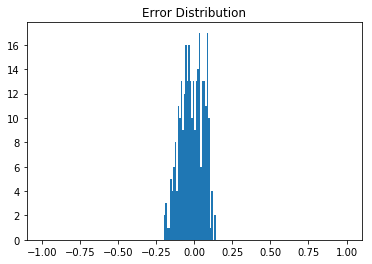

In [47]:
TEST = 300
correct = 0
tol = 0.1
errors = []
for i in range(TEST):
    print(f"TESTING {i + 1}/{TEST}", end = "\r")
    amt, inp = accelerating_distance_gen(ci)

    #run this to get FCN output
    out = model(inp).detach().numpy()
    
    #run this to use analytical output
    #out = approximate_amount(inp)

    if (abs(out - amt) < tol):
        correct += 1
    errors.append(out - amt)
print(f"WITHIN {tol} {correct}/{TEST} times")
print(f"AVERAGE ERROR {np.mean(np.abs(errors))}")

plt.title("Error Distribution")
plt.hist(errors, bins = 200, range = (-1, 1))
plt.show()